# Importing libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt

# Importing the training data

In [2]:
train_data = pd.read_csv('historical_data.csv',parse_dates =[1,2])
test_data = pd.read_csv('predict_data.csv',parse_dates =[1])

In [3]:
train_data.head()

market_id          created_at actual_delivery_time  store_id  \
0        1.0 2015-02-06 22:24:00  2015-02-06 23:27:00      1845   
1        2.0 2015-02-10 21:49:00  2015-02-10 22:56:00      5477   
2        3.0 2015-01-22 20:39:00  2015-01-22 21:09:00      5477   
3        3.0 2015-02-03 21:21:00  2015-02-03 22:13:00      5477   
4        3.0 2015-02-15 02:40:00  2015-02-15 03:20:00      5477   

  store_primary_category  order_protocol  total_items  subtotal  \
0               american             1.0            4      3441   
1                mexican             2.0            1      1900   
2                    NaN             1.0            1      1900   
3                    NaN             1.0            6      6900   
4                    NaN             1.0            3      3900   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1            1400            1400                    1.0   
2                   1            1900            1900                    1.0   
3                   5             600            1800                    1.0   
4                   3            1100            1600                    6.0   

   total_busy_dashers  total_outstanding_orders  \
0                14.0                      21.0   
1                 2.0                       2.0   
2                 0.0                       0.0   
3                 1.0                       2.0   
4                 6.0                       9.0   

   estimated_order_place_duration  \
0                             446   
1                             446   
2                             446   
3                             446   
4                             446   

   estimated_store_to_consumer_driving_duration  
0                                         861.0  
1                                         690.0  
2                                         690.0  
3                                         289.0  
4                                         650.0

# Data engineering

## Delivery time

In [5]:
train_data['Duration'] = train_data['actual_delivery_time'] - train_data['created_at']
train_data['Duration'] = train_data['Duration'].dt.seconds

# drop the rows with delivery time more than three hours
train_data = train_data[train_data['Duration']<=10800]

## Dropping irrelevant columns

In [6]:
created_at = train_data.created_at
actual_delivery_time = train_data.actual_delivery_time

train_data = train_data.drop(columns = ['created_at','actual_delivery_time'])

## Summary of features

In [7]:
# converting negative values to nan
store_primary_category = train_data.store_primary_category
train_data = train_data.drop(columns=['store_primary_category']).applymap(lambda x:x if x>=0 else float('nan'))
train_data['store_primary_category'] = store_primary_category

In [8]:
def ds_summry(Mod_df_2):
    msng = ((Mod_df_2.isnull().sum()/len(Mod_df_2))*100).apply(round,args=(2,))
    uniq,max_v,min_v = Mod_df_2.nunique(),Mod_df_2.max(),Mod_df_2.min()
    df_stats = pd.concat([msng, uniq,max_v,min_v], axis=1).rename(index=str, 
                                                                  columns={0: "% missing", 1: "No_uniq",2:'Max_Val',3:'Min_Val'})
    return df_stats

ds_summry(train_data)


% missing  No_uniq  Max_Val  \
market_id                                          0.50        6      6.0   
store_id                                           0.00     6742   6987.0   
order_protocol                                     0.50        7      7.0   
total_items                                        0.00       57    411.0   
subtotal                                           0.00     8367  27100.0   
num_distinct_items                                 0.00       20     20.0   
min_item_price                                     0.01     2300  14700.0   
max_item_price                                     0.00     2652  14700.0   
total_onshift_dashers                              8.25      168    171.0   
total_busy_dashers                                 8.25      154    154.0   
total_outstanding_orders                           8.26      275    285.0   
estimated_order_place_duration                     0.00       98   2715.0   
estimated_store_to_consumer_driving_duration       0.27     1335   2088.0   
Duration                                           0.00      178  10800.0   
store_primary_category                             2.41       74      NaN   

                                              Min_Val  
market_id                                         1.0  
store_id                                          1.0  
order_protocol                                    1.0  
total_items                                       1.0  
subtotal                                          0.0  
num_distinct_items                                1.0  
min_item_price                                    0.0  
max_item_price                                    0.0  
total_onshift_dashers                             0.0  
total_busy_dashers                                0.0  
total_outstanding_orders                          0.0  
estimated_order_place_duration                    0.0  
estimated_store_to_consumer_driving_duration      0.0  
Duration                                        120.0  
store_primary_category                            NaN

## Handling categorical data and nan values

In [9]:
print('columns with null values:')
train_data.isnull().any(axis=0)

columns with null values:


market_id                                        True
store_id                                        False
order_protocol                                   True
total_items                                     False
subtotal                                        False
num_distinct_items                              False
min_item_price                                   True
max_item_price                                  False
total_onshift_dashers                            True
total_busy_dashers                               True
total_outstanding_orders                         True
estimated_order_place_duration                  False
estimated_store_to_consumer_driving_duration     True
Duration                                        False
store_primary_category                           True
dtype: bool

### market_id

In [10]:
# market_id: adding a new class for missing values:

train_data.loc[train_data['market_id'].isnull(),'market_id'] = 0

### store_id

In [11]:
# store_id: convert to numerical classes:

from sklearn import preprocessing
le_strid = preprocessing.LabelEncoder()
le_strid.fit(train_data['store_id'])
train_data['store_id_t'] = le_strid.transform(train_data['store_id'])
train_data.drop(['store_id'],axis = 1, inplace = True)

### order_protocol

In [12]:
# order_protocol: adding a new class for missing values:

train_data.loc[train_data['order_protocol'].isnull(),'order_protocol'] = 0

### min_item_price, total_onshift_dashers, total_busy_dashers, total_outstanding_orders, estimated_store_to_consumer_driving_duration

In [20]:
# impute with median value:

for i in ['min_item_price','total_onshift_dashers','total_busy_dashers','total_outstanding_orders',
          'estimated_store_to_consumer_driving_duration']:
    
    train_data.loc[train_data[i].isnull(),i] = train_data[i].median()
    
# onshift dashers < busy dashers !!

train_data['total_onshift_dashers'] = np.where(train_data['total_busy_dashers']>train_data['total_onshift_dashers'],
                                             train_data['total_busy_dashers'],train_data['total_onshift_dashers'])


### store_primary_category

In [39]:
# store_primary_category: adding a new class for missing values and encode to numerical classes:

train_data.loc[train_data['store_primary_category'].isnull(),'store_primary_category'] = 'miss'
le_str_ctg = preprocessing.LabelEncoder()
le_str_ctg.fit(train_data['store_primary_category'])
train_data['store_primary_category_t'] = le_str_ctg.transform(train_data['store_primary_category'])

train_data.drop(['store_primary_category'],axis = 1, inplace = True)

## Adding new features:

### Day, Hour, Shift

In [41]:
# Busy hours depend on day, hour and shift of the order

train_data['Deliv_Day'] = created_at.dt.weekday
train_data['Deliv_hour'] = created_at.dt.hour

def shift(x):
    if x >6 and x<12:
        return 1    # 'Morning'
    elif x >=12 and x<=17:
        return 2    #'Lunch'
    elif x >17 and x<24:
        return 3    #'Dinner'
    else:
        return 4    #'Early_Morning'
        
train_data['Deliver_shift'] = train_data['Deliv_hour'].apply(shift)

### Percentage of free dashers

In [42]:
# % of free dashers at any given time

train_data['%_Dashers_free'] = np.where((train_data['total_busy_dashers'] + train_data['total_onshift_dashers'] ==0) , 0,
                                      (1 - (train_data['total_busy_dashers']/train_data['total_onshift_dashers']))*100)


### Ratio of dashers and orders

In [43]:
# No of free dashers to no of outstanding orders at a given time

train_data['Free_Dash/Outdng_Orders'] = np.where((train_data['total_outstanding_orders'] ==0) , 0,
                                               (train_data['total_onshift_dashers'] - 
                                                train_data['total_busy_dashers'])/train_data['total_outstanding_orders'])


## Summary of new features

In [44]:
ds_summry(train_data)

% missing  No_uniq  Max_Val  \
market_id                                           0.0        7      6.0   
order_protocol                                      0.0        8      7.0   
total_items                                         0.0       57    411.0   
subtotal                                            0.0     8367  27100.0   
num_distinct_items                                  0.0       20     20.0   
min_item_price                                      0.0     2300  14700.0   
max_item_price                                      0.0     2652  14700.0   
total_onshift_dashers                               0.0      168    171.0   
total_busy_dashers                                  0.0      154    154.0   
total_outstanding_orders                            0.0      275    285.0   
estimated_order_place_duration                      0.0       98   2715.0   
estimated_store_to_consumer_driving_duration        0.0     1335   2088.0   
Duration                                            0.0      178  10800.0   
store_id_t                                          0.0     6742   6741.0   
store_primary_category_t                            0.0       75     74.0   
Deliv_Day                                           0.0        7      6.0   
Deliv_hour                                          0.0       18     23.0   
Deliver_shift                                       0.0        4      4.0   
%_Dashers_free                                      0.0     2247    100.0   
Free_Dash/Outdng_Orders                             0.0     3125     32.0   

                                              Min_Val  
market_id                                         0.0  
order_protocol                                    0.0  
total_items                                       1.0  
subtotal                                          0.0  
num_distinct_items                                1.0  
min_item_price                                    0.0  
max_item_price                                    0.0  
total_onshift_dashers                             0.0  
total_busy_dashers                                0.0  
total_outstanding_orders                          0.0  
estimated_order_place_duration                    0.0  
estimated_store_to_consumer_driving_duration      0.0  
Duration                                        120.0  
store_id_t                                        0.0  
store_primary_category_t                          0.0  
Deliv_Day                                         0.0  
Deliv_hour                                        0.0  
Deliver_shift                                     1.0  
%_Dashers_free                                    0.0  
Free_Dash/Outdng_Orders                           0.0

# Pre-processing data

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = train_data.drop(['Duration'],axis = 1)
y = train_data[['Duration']]

# Breaking up into train/test  set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=10)

# Scaling the X variables for train set
scaler = StandardScaler().fit(X_train) 

# Models

## Evaluation Metrics

In [267]:
# MSE
from sklearn.metrics import mean_squared_error

#MAE
from sklearn.metrics import mean_absolute_error

#less than 5mins-error accuracy
def acc_5(ytrue,yhat):
    return np.mean(ytrue-yhat<5*60)

#less than 10mins-error accuracy
def acc_10(ytrue,yhat): 
    return np.mean(ytrue-yhat<10*60)

## Decision Tree

In [268]:
from sklearn.tree import DecisionTreeRegressor

ytrue = np.reshape(y_test.to_numpy(),(y_test.shape[0]))

dtr = DecisionTreeRegressor(max_depth = 11, min_samples_leaf = 12, random_state = 0)
dtr.fit(scaler.transform(X_train), y_train)

yhat = dtr.predict(scaler.transform(X_test))

mse = mean_squared_error(y_test, yhat)
mae = mean_absolute_error(y_test, yhat)
acc5 = acc_5(ytrue, yhat)
acc10 = acc_10(ytrue, yhat)

print('Decision Regressor MSE \t\t\t\t', round(mse,2))
print('Decision Regressor MAE \t\t\t\t', round(mae,2))
print('Decision Regressor % Less that 5 mins late \t', round(acc5*100,2),'%')
print('Decision Regressor % Less that 10 mins late \t', round(acc10*100,2),'%')

Decision Regressor MSE 				 914554.36
Decision Regressor MAE 				 704.14
Decision Regressor % Less that 5 mins late 	 69.32 %
Decision Regressor % Less that 10 mins late 	 79.02 %


## Random Forest

In [269]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators =100)
rf.fit(scaler.transform(X_train), y_train)

yhat = rf.predict(scaler.transform(X_test))

mse = mean_squared_error(y_test, yhat)
mae = mean_absolute_error(y_test, yhat)
acc5 = acc_5(ytrue, yhat)
acc10 = acc_10(ytrue, yhat)

print('Random Forest Regressor MSE \t\t\t\t', round(mse,2))
print('Random Forest Regressor MAE \t\t\t\t', round(mae,2))
print('Random Forest Regressor % Less that 5 mins late \t', round(acc5*100,2),'%')
print('Random Forest Regressor % Less that 10 mins late \t', round(acc10*100,2),'%')

Random Forest Regressor MSE 				 819392.22
Random Forest Regressor MAE 				 668.6
Random Forest Regressor % Less that 5 mins late 	 71.77 %
Random Forest Regressor % Less that 10 mins late 	 81.06 %


## Gradient Boosting

In [272]:
from sklearn.ensemble.gradient_boosting import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators =100, max_depth=11, max_features = 12,
                                    random_state=0, learning_rate=0.01, loss='ls')
gbr.fit(scaler.transform(X_train), y_train) 

yhat = gbr.predict(scaler.transform(X_test))

mse = mean_squared_error(y_test, yhat)
mae = mean_absolute_error(y_test, yhat)
acc5 = acc_5(ytrue, yhat)
acc10 = acc_10(ytrue, yhat)

print('Gradient Boosting Regressor MSE \t\t\t', round(mse,2))
print('Gradient Boosting Regressor MAE \t\t\t', round(mae,2))
print('Gradient Boosting Regressor % Less that 5 mins late \t', round(acc5*100,2),'%')
print('Gradient Boosting Regressor % Less that 10 mins late \t', round(acc10*100,2),'%')

Gradient Boosting Regressor MSE 			 889443.05
Gradient Boosting Regressor MAE 			 696.55
Gradient Boosting Regressor % Less that 5 mins late 	 70.52 %
Gradient Boosting Regressor % Less that 10 mins late 	 79.37 %


## Extra Trees

In [274]:
from sklearn.ensemble import ExtraTreesRegressor

etr = ExtraTreesRegressor(n_estimators=200, random_state=0)
etr.fit(scaler.transform(X_train), y_train) 

yhat = etr.predict(scaler.transform(X_test))

mse = mean_squared_error(y_test, yhat)
mae = mean_absolute_error(y_test, yhat)
acc5 = acc_5(ytrue, yhat)
acc10 = acc_10(ytrue, yhat)

print('Extra Trees Regressor MSE \t\t\t', round(mse,2))
print('Extra Trees Regressor MAE \t\t\t', round(mae,2))
print('Extra Trees Regressor % Less that 5 mins late \t', round(acc5*100,2),'%')
print('Extra Trees Regressor % Less that 10 mins late \t', round(acc10*100,2),'%')

Extra Trees Regressor MSE 			 799797.83
Extra Trees Regressor MAE 			 659.83
Extra Trees Regressor % Less that 5 mins late 	 72.03 %
Extra Trees Regressor % Less that 10 mins late 	 81.3 %


## AdaBOOST

In [276]:
from sklearn.ensemble import AdaBoostRegressor

ada = AdaBoostRegressor(base_estimator=dtr, n_estimators=100, random_state=0, learning_rate=0.01, loss='square')
ada.fit(scaler.transform(X_train), y_train)

yhat = ada.predict(scaler.transform(X_test))

mse = mean_squared_error(y_test, yhat)
mae = mean_absolute_error(y_test, yhat)
acc5 = acc_5(ytrue, yhat)
acc10 = acc_10(ytrue, yhat)

print('Adaboost Regressor MSE \t\t\t\t', round(mse,2))
print('Adaboost Regressor MAE \t\t\t\t', round(mae,2))
print('Adaboost Regressor % Less that 5 mins late \t', round(acc5*100,2),'%')
print('Adaboost Regressor % Less that 10 mins late \t', round(acc10*100,2),'%')

Adaboost Regressor MSE 				 855084.35
Adaboost Regressor MAE 				 678.12
Adaboost Regressor % Less that 5 mins late 	 69.96 %
Adaboost Regressor % Less that 10 mins late 	 79.35 %


## XGBoost

In [277]:
from xgboost import XGBRegressor

xgb = XGBRegressor()
xgb.fit(scaler.transform(X_train), y_train)

yhat = xgb.predict(scaler.transform(X_test))

mse = mean_squared_error(y_test, yhat)
mae = mean_absolute_error(y_test, yhat)
acc5 = acc_5(ytrue, yhat)
acc10 = acc_10(ytrue, yhat)

print('XGBoost Regressor MSE \t\t\t\t', round(mse,2))
print('XGBoost Regressor MAE \t\t\t\t', round(mae,2))
print('XGBoost Regressor % Less that 5 mins late \t', round(acc5*100,2),'%')
print('XGBoost Regressor % Less that 10 mins late \t', round(acc10*100,2),'%')

XGBoost Regressor MSE 				 764773.38
XGBoost Regressor MAE 				 637.31
XGBoost Regressor % Less that 5 mins late 	 70.94 %
XGBoost Regressor % Less that 10 mins late 	 80.79 %


## MLP

In [198]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Activation

from tensorflow import keras

def DNN():
    model = Sequential()
    model.add(Dense(50, input_dim=19, kernel_initializer='GlorotUniform', activation='relu'))
    model.add(Dense(50, activation='relu'))
    model.add(Dense(10, activation='relu'))
    model.add(Dense(10, activation='relu'))

    model.add(Dense(1, activation='relu'))
    optimizer = keras.optimizers.Adam(learning_rate=0.01)
    # Compile model
    model.compile(loss='mse', optimizer=optimizer)
    return model

model = DNN()
model.fit(scaler.transform(X_train), y_train, epochs=200, batch_size=256)

Epoch 1/200
128234/128234 [==============================] - 3s 20us/sample - loss: 1381832.7512
Epoch 2/200
128234/128234 [==============================] - 2s 12us/sample - loss: 869770.7895
Epoch 3/200
128234/128234 [==============================] - 2s 12us/sample - loss: 860135.2878
Epoch 4/200
128234/128234 [==============================] - 1s 12us/sample - loss: 854186.2630
Epoch 5/200
128234/128234 [==============================] - 2s 12us/sample - loss: 849601.1916
Epoch 6/200
128234/128234 [==============================] - 2s 13us/sample - loss: 849440.8812
Epoch 7/200
128234/128234 [==============================] - 1s 11us/sample - loss: 845609.1912
Epoch 8/200
128234/128234 [==============================] - 1s 11us/sample - loss: 844913.9243
Epoch 9/200
128234/128234 [==============================] - 1s 11us/sample - loss: 843298.7331
Epoch 10/200
128234/128234 [==============================] - 1s 12us/sample - loss: 843950.8708
Epoch 11/200
128234/128234 [==========

128234/128234 [==============================] - 2s 12us/sample - loss: 753466.6859
Epoch 169/200
128234/128234 [==============================] - 2s 13us/sample - loss: 751639.8653
Epoch 170/200
128234/128234 [==============================] - 2s 13us/sample - loss: 752381.2601
Epoch 171/200
128234/128234 [==============================] - 2s 13us/sample - loss: 752314.8917
Epoch 172/200
128234/128234 [==============================] - 2s 13us/sample - loss: 753330.5134
Epoch 173/200
128234/128234 [==============================] - 2s 12us/sample - loss: 751164.6168
Epoch 174/200
128234/128234 [==============================] - 2s 13us/sample - loss: 752195.3745
Epoch 175/200
128234/128234 [==============================] - 2s 12us/sample - loss: 752642.6626
Epoch 176/200
128234/128234 [==============================] - 1s 12us/sample - loss: 752231.4064
Epoch 177/200
128234/128234 [==============================] - 2s 14us/sample - loss: 751665.5421
Epoch 178/200
128234/128234 [=====

In [283]:
yhat = model.predict(scaler.transform(X_test))
yhat = np.reshape(yhat,(y_test.shape[0]))

mse = mean_squared_error(y_test, yhat)
mae = mean_absolute_error(y_test, yhat)
acc5 = acc_5(ytrue, yhat)
acc10 = acc_10(ytrue, yhat)

print('MLP MSE \t\t\t', round(mse,2))
print('MLP MAE \t\t\t', round(mae,2))
print('MLP % Less that 5 mins late \t', round(acc5*100,2),'%')
print('MLP % Less that 10 mins late \t', round(acc10*100,2),'%')

MLP MSE 			 803759.9
MLP MAE 			 657.58
MLP % Less that 5 mins late 	 71.37 %
MLP % Less that 10 mins late 	 80.82 %


# Graph visulization

#### The Extra trees model is best mdel in terms of all metrics. Since it is not possible to visualize Extra Trees, we visualize Decision Tree.

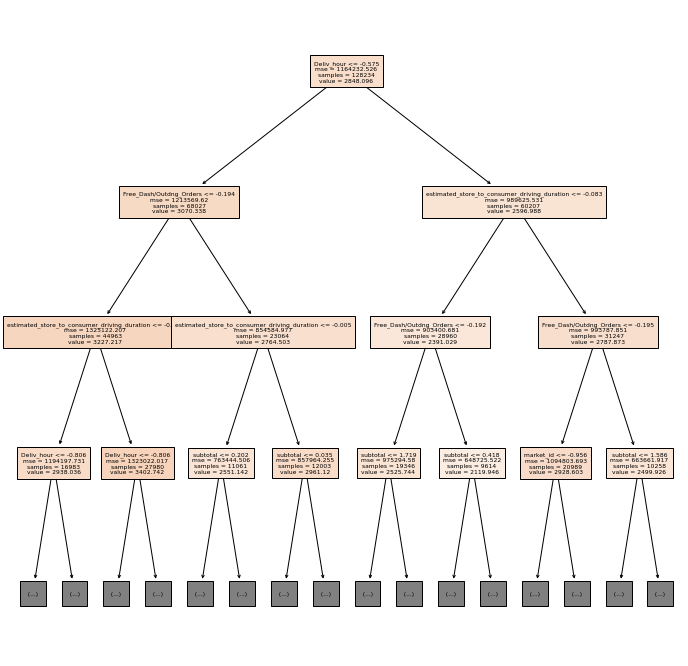

In [294]:
# fig = plt.figure(figsize=(25,20))
# _ = tree.plot_tree(dtr, 
#                    feature_names=list(X_train.columns),  
#                    filled=True)
plt.figure(figsize=(12,12))
tree.plot_tree(dtr, fontsize=6,feature_names=list(X_train.columns),filled=True,max_depth=3)
plt.savefig('tree_high_dpi_5_depth', dpi=100)

# Prediction on the test data

## Preparing test data

In [150]:
test_data = pd.read_csv('predict_data.csv',parse_dates =[1])
test_data.head()

market_id          created_at  store_id store_primary_category  \
0        3.0 2015-02-25 02:22:30      5477                    NaN   
1        3.0 2015-02-25 01:14:19      5477                    NaN   
2        4.0 2015-02-22 02:27:44      5477                   thai   
3        3.0 2015-02-25 01:32:39      5477                    NaN   
4        1.0 2015-02-24 05:20:45      2841                italian   

   order_protocol  total_items  subtotal  num_distinct_items  min_item_price  \
0             1.0            5      7500                   4             800   
1             1.0            5      7100                   4             800   
2             1.0            4      4500                   2             750   
3             1.0            1      1700                   1            1400   
4             1.0            2      3150                   2            1525   

   max_item_price  total_onshift_dashers  total_busy_dashers  \
0            1800                    4.0                 4.0   
1            1500                    4.0                 1.0   
2            1500                    9.0                 7.0   
3            1400                    3.0                 3.0   
4            1625                    4.0                 4.0   

   total_outstanding_orders  estimated_order_place_duration  \
0                       4.0                             446   
1                       1.0                             446   
2                       6.0                             446   
3                       3.0                             446   
4                       4.0                             446   

   estimated_store_to_consumer_driving_duration  delivery_id platform  
0                                         670.0       194096  android  
1                                         446.0       236895    other  
2                                         504.0       190868  android  
3                                         687.0       183076      ios  
4                                         528.0       186200  android

In [151]:
# dropping irrelevan columns:

created_at_test = test_data.created_at
delivery_id = test_data.delivery_id

test_data = test_data.drop(columns = ['created_at','delivery_id', 'platform'])

In [152]:
# converting negative values to nan

store_primary_category_test = test_data.store_primary_category
test_data = test_data.drop(columns=['store_primary_category']).applymap(lambda x:x if x>=0 else float('nan'))
test_data['store_primary_category'] = store_primary_category_test

In [153]:
ds_summry(test_data)

% missing  No_uniq  Max_Val  \
market_id                                          0.46        6      6.0   
store_id                                           0.00     5676   6986.0   
order_protocol                                     0.52        7      7.0   
total_items                                        0.00       46     81.0   
subtotal                                           0.00     6044  29925.0   
num_distinct_items                                 0.00       19     19.0   
min_item_price                                     0.01     1725  25040.0   
max_item_price                                     0.00     1929  25142.0   
total_onshift_dashers                              8.46      174    175.0   
total_busy_dashers                                 8.48      168    169.0   
total_outstanding_orders                           8.48      266    292.0   
estimated_order_place_duration                     0.00        5   1095.0   
estimated_store_to_consumer_driving_duration       0.02     1241   1550.0   
store_primary_category                             2.45       71      NaN   

                                              Min_Val  
market_id                                         1.0  
store_id                                          2.0  
order_protocol                                    1.0  
total_items                                       1.0  
subtotal                                          0.0  
num_distinct_items                                1.0  
min_item_price                                    0.0  
max_item_price                                    0.0  
total_onshift_dashers                             0.0  
total_busy_dashers                                0.0  
total_outstanding_orders                          0.0  
estimated_order_place_duration                    0.0  
estimated_store_to_consumer_driving_duration      0.0  
store_primary_category                            NaN

In [154]:
# handling categorical and nan values

test_data.loc[test_data['market_id'].isnull(),'market_id'] = 0

# unseen store id:
le_dict = dict(zip(le_strid.classes_, le_strid.transform(le_strid.classes_)))
sid = np.zeros(test_data.shape[0])
for i in range(test_data.shape[0]):
    try:
        sid[i] = le_dict[test_data['store_id'][i]]
    except:
        sid[i] = len(le_dict)

test_data['store_id_t'] = sid
test_data.drop(['store_id'],axis = 1, inplace = True)


test_data.loc[test_data['order_protocol'].isnull(),'order_protocol'] = 0


for i in ['min_item_price','total_onshift_dashers','total_busy_dashers','total_outstanding_orders',
          'estimated_store_to_consumer_driving_duration']:    
    test_data.loc[test_data[i].isnull(),i] = train_data[i].median()
    

test_data['total_onshift_dashers'] = np.where(test_data['total_busy_dashers']>test_data['total_onshift_dashers'],
                                             test_data['total_busy_dashers'],test_data['total_onshift_dashers'])


test_data.loc[test_data['store_primary_category'].isnull(),'store_primary_category'] = 'miss'
test_data['store_primary_category_t'] = le_str_ctg.transform(test_data['store_primary_category'])
test_data.drop(['store_primary_category'],axis = 1, inplace = True)




test_data['Deliv_Day'] = created_at_test.dt.weekday
test_data['Deliv_hour'] = created_at_test.dt.hour
test_data['Deliver_shift'] = test_data['Deliv_hour'].apply(shift)

test_data['%_Dashers_free'] = np.where((test_data['total_busy_dashers'] + test_data['total_onshift_dashers'] ==0) , 0,
                                      (1 - (test_data['total_busy_dashers']/test_data['total_onshift_dashers']))*100)


test_data['Free_Dash/Outdng_Orders'] = np.where((test_data['total_outstanding_orders'] ==0) , 0,
                                               (test_data['total_onshift_dashers'] - 
                                                test_data['total_busy_dashers'])/test_data['total_outstanding_orders'])


In [159]:
ds_summry(test_data)

% missing  No_uniq  Max_Val  \
market_id                                           0.0        7      6.0   
order_protocol                                      0.0        8      7.0   
total_items                                         0.0       46     81.0   
subtotal                                            0.0     6044  29925.0   
num_distinct_items                                  0.0       19     19.0   
min_item_price                                      0.0     1725  25040.0   
max_item_price                                      0.0     1929  25142.0   
total_onshift_dashers                               0.0      174    175.0   
total_busy_dashers                                  0.0      168    169.0   
total_outstanding_orders                            0.0      266    292.0   
estimated_order_place_duration                      0.0        5   1095.0   
estimated_store_to_consumer_driving_duration        0.0     1241   1550.0   
store_id_t                                          0.0     5433   6742.0   
store_primary_category_t                            0.0       72     74.0   
Deliv_Day                                           0.0        7      6.0   
Deliv_hour                                          0.0       18     23.0   
Deliver_shift                                       0.0        4      4.0   
%_Dashers_free                                      0.0     1461    100.0   
Free_Dash/Outdng_Orders                             0.0     1823     11.0   

                                              Min_Val  
market_id                                         0.0  
order_protocol                                    0.0  
total_items                                       1.0  
subtotal                                          0.0  
num_distinct_items                                1.0  
min_item_price                                    0.0  
max_item_price                                    0.0  
total_onshift_dashers                             0.0  
total_busy_dashers                                0.0  
total_outstanding_orders                          0.0  
estimated_order_place_duration                    0.0  
estimated_store_to_consumer_driving_duration      0.0  
store_id_t                                        1.0  
store_primary_category_t                          0.0  
Deliv_Day                                         0.0  
Deliv_hour                                        0.0  
Deliver_shift                                     1.0  
%_Dashers_free                                    0.0  
Free_Dash/Outdng_Orders                           0.0

In [215]:
pred_dtr = dtr.predict(scaler.transform(test_data))

pd.DataFrame(np.column_stack((delivery_id,pred_dtr)),index=None,columns=['delivery_id','predicted duration (seconds)']).to_csv("DecisionTree.csv",index=None)


In [216]:
pred_rf = rf.predict(scaler.transform(test_data))

pd.DataFrame(np.column_stack((delivery_id,pred_rf)),index=None,columns=['delivery_id','predicted duration (seconds)']).to_csv("RandomForest.csv",index=None)


In [218]:
pred_gbr = gbr.predict(scaler.transform(test_data))

pd.DataFrame(np.column_stack((delivery_id,pred_gbr)),index=None,columns=['delivery_id','predicted duration (seconds)']).to_csv("GradientBoosting.csv",index=None)


In [220]:
pred_etr = etr.predict(scaler.transform(test_data))

pd.DataFrame(np.column_stack((delivery_id,pred_etr)),index=None,columns=['delivery_id','predicted duration (seconds)']).to_csv("ExtraTrees.csv",index=None)


In [222]:
pred_ada = ada.predict(scaler.transform(test_data))

pd.DataFrame(np.column_stack((delivery_id,pred_ada)),index=None,columns=['delivery_id','predicted duration (seconds)']).to_csv("AdaBoost.csv",index=None)


In [224]:
pred_xgb = xgb.predict(scaler.transform(test_data))

pd.DataFrame(np.column_stack((delivery_id,pred_xgb)),index=None,columns=['delivery_id','predicted duration (seconds)']).to_csv("XGBoost.csv",index=None)


In [226]:
pred_mlp = model.predict(scaler.transform(test_data))

pd.DataFrame(np.column_stack((delivery_id,pred_mlp)),index=None,columns=['delivery_id','predicted duration (seconds)']).to_csv("DNN.csv",index=None)


In [285]:
list(X_train.columns) 

['market_id',
 'order_protocol',
 'total_items',
 'subtotal',
 'num_distinct_items',
 'min_item_price',
 'max_item_price',
 'total_onshift_dashers',
 'total_busy_dashers',
 'total_outstanding_orders',
 'estimated_order_place_duration',
 'estimated_store_to_consumer_driving_duration',
 'store_id_t',
 'store_primary_category_t',
 'Deliv_Day',
 'Deliv_hour',
 'Deliver_shift',
 '%_Dashers_free',
 'Free_Dash/Outdng_Orders']